# ECE 6254 - Statistical Machine Learning
## Project 
### Mathematical Analysis of Cost Sensitive Learning 

#### Import Libraries

In [94]:
import numpy as np
from scipy.stats import multivariate_normal as Normal
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from sklearn.naive_bayes import GaussianNB
from math import sqrt
from sklearn.metrics import f1_score, roc_curve
from tqdm import tqdm

my_colors = [(0,0,1),(1,0,0)]
my_cm = LinearSegmentedColormap.from_list('my_cm', my_colors, N=2)

#### Functions definitions for plots 

In [2]:

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N

def GaussianBayesClassifier(x,priors, gaussians):
    pyx1 = multivariate_gaussian(x, gaussians[0][0], gaussians[0][1])
    pyx2 = multivariate_gaussian(x, gaussians[1][0], gaussians[1][1])
    
    y_pred = np.zeros(x.shape[:2])
    for i in range(len(x)):
        for j in range(len(x)):
            #print('%.3f vs. %.3f' % (np.log(priors[0]) + np.log(pyx1[i,j]), np.log(priors[1]) + np.log(pyx2[i,j])))
            if np.log(priors[0]) + np.log(pyx1[i,j]) > np.log(priors[1]) + np.log(pyx2[i,j]):
                y_pred[i,j] = -1
            else:
                y_pred[i,j] = 1
    return y_pred

def hBayes(x, priors, gaussians):
    h0 = priors[0] * Normal.pdf(x,gaussians[0][0], gaussians[0][1])
    h1 = priors[1] * Normal.pdf(x, gaussians[1][0], gaussians[1][1])
    y_pred = np.zeros([len(h0),1])
    for i in range(len(h0)):
        if h0[i] > h1[i]:
            y_pred[i] = -1
        else:
            y_pred[i] = 1
    return y_pred

def Plot2DGaussians(grid, Z1, Z2, Zpred):
    x_grid, y_grid = grid
    fig = plt.figure()
    ax1 = fig.add_subplot(3,1,1,projection='3d')
    
    ax1.plot_surface(x_grid, y_grid, Z2, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis, alpha=0.8)
    ax1.plot_surface(x_grid, y_grid, Z1, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.Spectral, alpha=0.7)
    
    ax1.view_init(20,-70)
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel(r'$x_2$')
    
    ax2 = fig.add_subplot(3,1,2,projection='3d')
    ax2.contourf(x_grid, y_grid, Z2, zdir='z', offset=0, cmap=cm.viridis, alpha=0.8, antialiased=True)
    ax2.contourf(x_grid, y_grid, Z1, zdir='z', offset=0, cmap=cm.Spectral, alpha=0.5, antialiased=True)
    ax2.view_init(90, 270)
    
    ax2.grid(False)
    ax2.set_zticks([])
    ax2.set_xlabel(r'Coordinate $x_1$')
    ax2.set_ylabel(r'Coordinate $x_2$')
    
    ax3 = fig.add_subplot(3,1,3)
    plt.contourf(x_grid,y_grid,Zpred,levels=[-1,0,1], cmap = my_cm, alpha=0.2)
    plt.contour(x_grid,y_grid,Zpred,linewidth=2,colors='k')
    ax3.set_xlabel(r'Coordinate $x_1$')
    ax3.set_ylabel(r'Coordinate $x_2$')
    ax3.set_title(r'Decision Region')
    
    plt.show()
    return

def PlotDataAndClassification(grid, X1, X2, Zpred, title):
    x_grid,y_grid = grid
    plt.figure()
    
    # Plot data points
    plt.plot(X1[:,0],X1[:,1],'o',color='b',label='Class 1')
    plt.plot(X2[:,0],X2[:,1],'o',color='r',label='Class 2')
    
    # Plot classification region
    plt.contourf(x_grid,y_grid,Zpred,levels=[-1,0,1], cmap = my_cm, alpha=0.2)
    plt.contour(x_grid,y_grid,Zpred,linewidth=2,colors='k')
    
    # Set labels
    plt.xlabel(r'Coordinate $x_1$')
    plt.ylabel(r'Coordinate $x_2$')
    plt.legend(loc='lower right',fontsize='x-small')
    plt.title(title)

    return

## 1. Analysis of cost-sensitive techniques impact on Bayes classifier
In this section, we will analyze the impact of the cost-sensitive bayes classifier on the decision region, based on a 2D example.

#### Definition of Distribution Parameters

In [57]:
#pi_mi = 0.3    # Proportion of minority class
#N = 1e7       # Total number of samples
#mu_mi = 0
#sigma_mi = 3
#mu_ma = 3
#sigma_ma = 3

In [63]:
x_grid = np.linspace(-5,5,100)
y_grid = np.linspace(-5,5, 100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(x_grid.shape + (2,))
pos[:, :, 0] = x_grid
pos[:, :, 1] = y_grid

# Define Gaussians 
pi_mi = 0.15
pi_ma = 1-pi_mi
N = 1e7         
mu_mi = [-1,-0.5]
sigma_mi = [[1,0],[0,1]]
mu_ma = [0,1]
sigma_ma = [[4,0],[0,2]]

#### Plot of impact on priors in the distributions

/Users/peces/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: The following kwargs were not used by contour: 'linewidth'


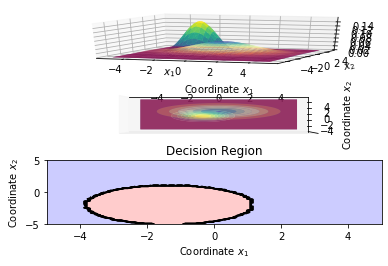

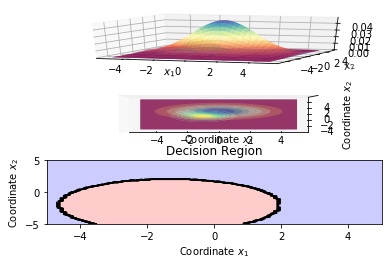

In [64]:
x_grid = np.linspace(-5,5,100)
y_grid = np.linspace(-5,5,100)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(x_grid.shape + (2,))
pos[:, :, 0] = x_grid
pos[:, :, 1] = y_grid

# Definition of distributions
Z1 = multivariate_gaussian(pos, np.array(mu_ma), np.array(sigma_ma))
Z2 = multivariate_gaussian(pos, np.array(mu_mi), np.array(sigma_mi))
gaussians = [[np.array(mu_ma),np.array(sigma_ma)],[np.array(mu_mi), np.array(sigma_mi)]]

# Plot Distributions
Z_bayes_balanced = GaussianBayesClassifier(pos,[0.5, 0.5], gaussians)
Plot2DGaussians([x_grid,y_grid], Z1, Z2, Z_bayes_balanced)

# Make assumptions on priors and plot (one can force trivial classification setting prior1=0.99)
Z_bayes_unbalanced = GaussianBayesClassifier(pos,[pi_mi, pi_ma], gaussians)
Plot2DGaussians([x_grid,y_grid], Z1*pi_ma, Z2*pi_mi, Z_bayes_unbalanced)

## 2. Implementation of Cost-Sensitive classifiers

In [65]:
class NaiveBayes_CostSensitive:
    def __init__(self, x=None,y=None,cost=None):
        """
        NaiveBayes creates a cost-sensitive binary classifier based on dataset {x,y} 
        applying a specified cost over the feature distributions. Assumes
        2 features and binary class.
        
        x: Feature vector. Should be size N x 2
        y: Class vector. Should be size N x 1
        cost: Should be between 0 and 1. 
        
        """
        try:
            self.fit(x,y,cost)
        except:
            pass
    
    def fit(self, x, y, cost = None):
        # Get data
        x1, x2 = x[np.where(y>0.5)[0]], x[np.where(y<0.5)[0]]
        y1, y2 = y[np.where(y>0.5)[0]], y[np.where(y<0.5)[0]]
        self.y1, self.y2 = y1[0], y2[0]
        
        # Get priors
        self.prior1 = len(y1)/(len(y1)+len(y2))
        self.prior2 = len(y2)/(len(y1)+len(y2))
        
        # Get mean and covariance based on data
        self.cov1, self.cov2 = np.zeros([2,2]), np.zeros([2,2])
        self.mean1 = np.mean(x1,0)
        self.mean2 = np.mean(x2,0)
        self.cov1[0,0], self.cov1[1,1] = np.var(x1,0)[0], np.var(x1,0)[1]
        self.cov2[0,0], self.cov2[1,1] = np.var(x2,0)[0], np.var(x2,0)[1]

        if cost is not None:
            if self.prior1 > self.prior1:
                self.prior1 *= (1-cost)
                self.prior2 *= cost 
            else:
                self.prior1 *= cost
                self.prior2 *= (1-cost)
    
    def predict(self, x):
        x1 = self.prior1 * Normal.pdf(x, self.mean1, self.cov1)
        x2 = self.prior2 * Normal.pdf(x, self.mean2, self.cov2)
        y_pred = np.zeros([len(x),1])
        for i in range(len(x)):
            if x1[i] > x2[i]:
                y_pred[i] = self.y1
            else:
                y_pred[i] = self.y2
        return y_pred

In [71]:
class KKNClasifier_CostSensitive:
    def __init__(self, x=None,y=None,cost=None, n_neighbors = 5):
        """
        KKNClasifier creates a cost-sensitive binary classifier based on dataset {x,y} 
        applying a specified cost over the feature distributions. Assumes
        2 features and binary class. Uses Euclidean distance.
        
        x: Feature vector. Should be size N x 2
        y: Class vector. Should be size N x 1
        cost: Should be greater than 1. It is the ratio of preference againts 
        the majority class. For example if it is set to 2, will predict the 
        majority class after reaching 2 * n_neighbors.
        
        """
        
        # Store input
        self.n_neighbors = n_neighbors
        try:
            self.fit(x,y,cost)
        except:
            pass

    def fit(self, x, y, cost):
        self.x = x
        self.y = y

        if cost is None:
            self.ratio = 1
        else:
            self.ratio = cost
            
        y1, y2 = y[np.where(y>0.5)[0]], y[np.where(y<0.5)[0]]
        self.y1, self.y2 = y1[0], y2[0]

        if len(y1) > len(y2):
            self.limit_y1 = int(self.n_neighbors * self.ratio)
            self.limit_y2 = self.n_neighbors
        else:
            self.limit_y2 = int(self.n_neighbors * self.ratio)
            self.limit_y1 = self.n_neighbors

    def square_euclidean_distance(self,x):
        # Subtract each element by row
        sub_vector = self.x - x
        
        # Get distances
        return np.linalg.norm(sub_vector, axis = 1)
        
        
    def predict(self, x):
        # Choose output for each input
        y_pred = np.zeros([len(x),1])
        
        for row in range(len(x)):
            distance = self.square_euclidean_distance(x[row,:])
            #print(distance)
            #input()
            idx_lowest_values = np.argpartition(distance, int(np.ceil(2 * self.n_neighbors * self.ratio)))
            cont_y1 = 0
            cont_y2 = 0
            for idx in idx_lowest_values:
                if self.y[idx] == self.y1:
                    cont_y1 += 1
                else:
                    cont_y2 += 1
                
                if cont_y1 == self.limit_y1:
                    last = self.y1
                    break
                if cont_y2 == self.limit_y2:
                    last = self.y2
                    break
            #print('predicted: ' + str(last))
            y_pred[row,:] = last
                    
        return y_pred
        
        

## 3. Study of Cost impact in the classification

#### Generate Training Dataset

In [130]:
pi_mi = 0.1
pi_ma = 1-pi_mi
N = 1e7         
mu_mi = [-1,-0.5]
sigma_mi = [[1,0],[0,1]]
mu_ma = [0,1]
sigma_ma = [[4,0],[0,2]]
N=1e6
x2D_ma = np.random.multivariate_normal(mu_ma,sigma_ma,int((1-pi_mi)*N))
x2D_mi = np.random.multivariate_normal(mu_mi,sigma_mi,int(pi_mi*N))

#### Classifiers creation

In [131]:
y_training = np.r_[[1]*len(x2D_ma), [-1]*len(x2D_mi)]
x_training = np.r_[x2D_ma,x2D_mi]
KKNClassifier = KKNClasifier_CostSensitive(n_neighbors=3)
KKNClassifier.fit(x_training,y_training,cost=None)
NBClassifier = NaiveBayes_CostSensitive()
NBClassifier.fit(x_training,y_training)

#### Prediction and Classification Evaluation

In [133]:
#np.random.seed(0)
N_test=1e3
x2D_ma_test = np.random.multivariate_normal(mu_ma,sigma_ma,int((1-pi_mi)*N_test))
x2D_mi_test = np.random.multivariate_normal(mu_mi,sigma_mi,int(pi_mi*N_test))

x_test = np.r_[x2D_ma_test,x2D_mi_test]
y_test = np.r_[[1]*len(x2D_ma_test), [-1]*len(x2D_mi_test)]

#y_pred = KKNClassifier.predict(x_test)
y_pred_bayes_base = NBClassifier.predict(x_test)
#f1_base_knn = f1_score(y_test, y_pred, average='weighted')
f1_base_bayes = f1_score(y_test, y_pred_bayes_base, average='weighted')
print(f1_base_bayes)

0.8678953810656049


#### Prediction modyfing the cost in the loss function

In [134]:
costs = [i for i in list(np.linspace(0.1,0.9,11))]
f1scores_bayes = []
#f1scores_knn = []
homog_it = 10

for c in tqdm(costs):
    aux_f1_b = np.zeros([1,homog_it])
    #aux_f1_k = np.zeros([1,homog_it])
    
    for i in range(homog_it): # Homogenize results
        x2D_ma_test = np.random.multivariate_normal(mu_ma,sigma_ma,int((1-pi_mi)*N_test))
        x2D_mi_test = np.random.multivariate_normal(mu_mi,sigma_mi,int(pi_mi*N_test))

        x_test = np.r_[x2D_ma_test,x2D_mi_test]
        y_test = np.r_[[1]*len(x2D_ma_test), [-1]*len(x2D_mi_test)]

        NBClassifier = NaiveBayes_CostSensitive()
        NBClassifier.fit(x_training, y_training, cost = c)
        #KKNClassifier = KKNClasifier_CostSensitive(n_neighbors=3)
        #KKNClassifier.fit(x_training,y_training,cost=1/c)
        
        y_pred_bayes = NBClassifier.predict(x_test)
        #y_pred_knn = KKNClassifier.predict(x_test)
        
        aux_f1_b[0,i] = f1_score(y_test, y_pred_bayes, average='weighted')
        #aux_f1_k[0,i] = f1_score(y_test, y_pred_knn, average='weighted')
        
    f1scores_bayes.append(np.mean(aux_f1_b))
    #f1scores_knn.append(np.mean(aux_f1_k))



  0%|          | 0/11 [00:00<?, ?it/s]

  9%|▉         | 1/11 [00:01<00:15,  1.52s/it]

 18%|█▊        | 2/11 [00:03<00:15,  1.68s/it]

 27%|██▋       | 3/11 [00:05<00:13,  1.72s/it]

 36%|███▋      | 4/11 [00:07<00:12,  1.76s/it]

 45%|████▌     | 5/11 [00:08<00:10,  1.68s/it]

 55%|█████▍    | 6/11 [00:10<00:08,  1.61s/it]

 64%|██████▎   | 7/11 [00:11<00:06,  1.57s/it]

 73%|███████▎  | 8/11 [00:13<00:04,  1.53s/it]

 82%|████████▏ | 9/11 [00:14<00:03,  1.51s/it]

 91%|█████████ | 10/11 [00:16<00:01,  1.49s/it]

100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


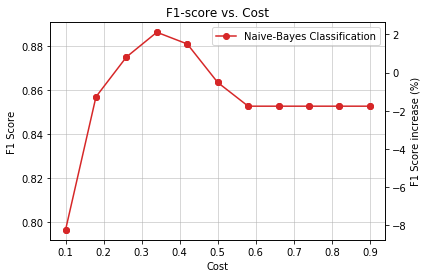

[0.7963256669173793, 0.8568965377259508, 0.8750037145223791, 0.8862788564637331, 0.8809319666835987, 0.8634235067505752, 0.8526315789473685, 0.8526315789473685, 0.8526315789473685, 0.8526315789473685, 0.8526315789473685]


In [138]:
# Plot results
plt.close()
fig = plt.figure()

ax1 = plt.subplot(111)
plt.grid(True,which='major',linewidth=0.5)
plt.grid(True,which='minor',linewidth=0.1)
#plt.plot(costs,f1scores_knn,'-o',color='tab:blue',label='KKN Classification')
plt.plot(costs,f1scores_bayes,'-o',color='tab:red',label='Naive-Bayes Classification')
ax1.set(title='F1-score vs. Cost', xlabel = 'Cost', ylabel = 'F1 Score')
plt.legend(loc='lower right')
plt.legend()

ax2 = ax1.twinx()
#plt.plot(costs,(f1scores_knn-f1_base_knn)/f1_base_knn*100,'o',color='tab:blue')
plt.plot(costs,(f1scores_bayes-f1_base_bayes)/f1_base_bayes*100,'o',color='tab:red')
ax2.set_ylabel('F1 Score increase (%)')
plt.show()
print(f1scores_bayes)

#### Comparing ROC curves.
We will compare the ROC curves including the undersampling technique.

In [136]:
# Get Optimum Beta results
cost = costs[3]
x2D_ma_test = np.random.multivariate_normal(mu_ma,sigma_ma,int((1-pi_mi)*N_test))
x2D_mi_test = np.random.multivariate_normal(mu_mi,sigma_mi,int(pi_mi*N_test))

x_test = np.r_[x2D_ma_test,x2D_mi_test]
y_test = np.r_[[1]*len(x2D_ma_test), [-1]*len(x2D_mi_test)]
NBClassifier = NaiveBayes_CostSensitive()
NBClassifier.fit(x_training, y_training, cost = c)
y_pred_bayes_cost_applied = NBClassifier.predict(x_test)

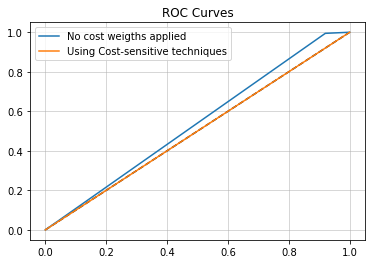

In [139]:
# Plot ROC curves
#a, b, _ = roc_curve(y_test, y_pred_bayes_base)
#c, d, _ = roc_curve(y_test, y_pred_bayes_cost_applied)

#plt.figure()
#plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(a, b, label = 'No cost weigths applied')
#plt.plot(c, d, label='Using Cost-sensitive techniques')
#plt.grid(True,which='major',linewidth=0.5)
#plt.grid(True,which='minor',linewidth=0.1)
#plt.title('ROC Curves')
#plt.legend()
#plt.show()

## 4. Risk Evaluation